In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Create triplets: (anchor, positive, negative)
def create_triplets(x, y):
    triplets = []
    num_classes = 10
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    for d in range(num_classes):
        pos_indices = digit_indices[d]
        neg_indices = np.hstack([digit_indices[i] for i in range(num_classes) if i != d])
        
        for i in range(len(pos_indices) - 1):
            anchor = x[pos_indices[i]]
            positive = x[pos_indices[i + 1]]
            negative = x[np.random.choice(neg_indices)]
            triplets.append([anchor, positive, negative])
    
    return np.array(triplets)

triplets_train = create_triplets(x_train, y_train)
triplets_test = create_triplets(x_test, y_test)

print("Triplets train shape:", triplets_train.shape)  # (num_triplets, 3, H, W, 1)

# Base network
def base_network(input_shape):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu")(input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)  # No activation
    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    return Model(input, x)

input_shape = x_train.shape[1:]
embedding_model = base_network(input_shape)

# Triplet model
anchor_input = layers.Input(shape=input_shape)
positive_input = layers.Input(shape=input_shape)
negative_input = layers.Input(shape=input_shape)

anchor_embedding = embedding_model(anchor_input)
positive_embedding = embedding_model(positive_input)
negative_embedding = embedding_model(negative_input)

triplet_model = Model([anchor_input, positive_input, negative_input],
                      [anchor_embedding, positive_embedding, negative_embedding])

# Triplet loss
def triplet_loss(_, embeddings):
    anchor, positive, negative = embeddings
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    margin = 0.5
    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)

# Wrap loss in a Lambda layer
class TripletLossLayer(layers.Layer):
    def call(self, inputs):
        loss = triplet_loss(None, inputs)
        self.add_loss(loss)
        return loss

loss_output = TripletLossLayer()([anchor_embedding, positive_embedding, negative_embedding])
training_model = Model([anchor_input, positive_input, negative_input], loss_output)

training_model.compile(optimizer='adam')
training_model.summary()

# Prepare training data
anchor = triplets_train[:, 0]
positive = triplets_train[:, 1]
negative = triplets_train[:, 2]

anchor_test = triplets_test[:, 0]
positive_test = triplets_test[:, 1]
negative_test = triplets_test[:, 2]

# Train
history = training_model.fit(
    [anchor, positive, negative], np.zeros(len(anchor)),
    validation_data=([anchor_test, positive_test, negative_test], np.zeros(len(anchor_test))),
    batch_size=128,
    epochs=10
)

# Plot dummy loss (from added_loss)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


2025-05-26 20:05:14.201247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-26 20:05:14.201284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-26 20:05:14.202375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 20:05:14.208613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-26 20:05:15.080071: W tensorflow/compiler/tf2

Triplets train shape: (59990, 3, 28, 28, 1)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  223744    ['input_2[0][0]',             
                                                

2025-05-26 20:05:21.096506: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188128640 exceeds 10% of free system memory.
2025-05-26 20:05:21.748990: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188128640 exceeds 10% of free system memory.


Epoch 1/10


2025-05-26 20:05:26.303025: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188128640 exceeds 10% of free system memory.


469/469 [==============================] - 56s 117ms/step - loss: 0.0243 - val_loss: 0.0095
Epoch 2/10
469/469 [==============================] - 52s 112ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 3/10
469/469 [==============================] - 47s 100ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 4/10
469/469 [==============================] - 49s 105ms/step - loss: 0.0033 - val_loss: 0.0061
Epoch 5/10
469/469 [==============================] - 52s 111ms/step - loss: 0.0026 - val_loss: 0.0061
Epoch 6/10
296/469 [=================>............] - ETA: 21s - loss: 0.0019

KeyboardInterrupt: 

we’re passing dummy labels (np.zeros(...)) because:

The actual loss is not computed from the labels, but directly from the embeddings (anchor, positive, negative).

model.fit() requires a y label argument — even if it’s not used — so we give a dummy array of zeros.

This is a common workaround when using custom loss layers like TripletLossLayer with add_loss().

❓ Why not use the triplet loss in model.compile(loss=...)?
Because the triplet loss depends on three outputs (anchor, positive, negative) and is not computed from model output vs. labels. Instead:

We define the triplet loss directly as a computation over model outputs, not as loss(y_true, y_pred).

By using a Lambda or custom Layer with add_loss(...), we bypass the need to define y_pred, which is awkward for triplet loss.

If we used compile(loss=triplet_loss), the triplet_loss() function would need to accept (y_true, y_pred), but we don’t use y_true at all here.

So, in this case, we attach the loss directly to the model via TripletLossLayer, and compile just defines the optimizer.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)  # (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)    # (10000, 28, 28, 1)

# Improved triplet creation (balanced sampling)
def create_triplets(x, y, num_triplets=5000):
    triplets = []
    num_classes = 10
    class_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    for _ in range(num_triplets):
        # Randomly select anchor class
        anchor_class = np.random.randint(0, num_classes)
        while len(class_indices[anchor_class]) < 2:  # Ensure enough samples
            anchor_class = np.random.randint(0, num_classes)
        
        # Select anchor and positive from same class
        anchor_idx, pos_idx = np.random.choice(class_indices[anchor_class], 2, replace=False)
        
        # Select negative from different class
        neg_class = np.random.randint(0, num_classes)
        while neg_class == anchor_class or len(class_indices[neg_class]) == 0:
            neg_class = np.random.randint(0, num_classes)
        neg_idx = np.random.choice(class_indices[neg_class])
        
        triplets.append([x[anchor_idx], x[pos_idx], x[neg_idx]])
    
    return np.array(triplets)

# Create triplets (fewer than original for memory efficiency)
triplets_train = create_triplets(x_train, y_train, num_triplets=10000)
triplets_test = create_triplets(x_test, y_test, num_triplets=2000)

# Base embedding network
def build_embedding_network(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)  # Smaller embedding (64D instead of 128D)
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    return Model(inputs, x)

# Siamese model that outputs distances
def build_siamese_model(embedding_network):
    anchor_input = layers.Input(shape=input_shape)
    positive_input = layers.Input(shape=input_shape)
    negative_input = layers.Input(shape=input_shape)
    
    # Shared weights
    a_embed = embedding_network(anchor_input)
    p_embed = embedding_network(positive_input)
    n_embed = embedding_network(negative_input)
    
    # Compute distances
    pos_dist = tf.reduce_sum(tf.square(a_embed - p_embed), axis=1)
    neg_dist = tf.reduce_sum(tf.square(a_embed - n_embed), axis=1)
    """
    pos_dist = layers.Lambda(lambda tensors: tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True))([a_embed, p_embed])
neg_dist = layers.Lambda(lambda tensors: tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True))([a_embed, n_embed])
    """
    
    return Model([anchor_input, positive_input, negative_input], [pos_dist, neg_dist])

# Triplet loss function
def triplet_loss(y_true, y_pred):
    pos_dist, neg_dist = y_pred[:, 0], y_pred[:, 1]
    margin = 0.5
    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)

# Build and compile
input_shape = x_train.shape[1:]
embedding_net = build_embedding_network(input_shape)
model = build_siamese_model(embedding_net)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=triplet_loss)

# Prepare data
anchor_train, positive_train, negative_train = triplets_train[:, 0], triplets_train[:, 1], triplets_train[:, 2]
anchor_test, positive_test, negative_test = triplets_test[:, 0], triplets_test[:, 1], triplets_test[:, 2]

# Train
history = model.fit(
    [anchor_train, positive_train, negative_train],
    batch_size=128,
    epochs=2,
    validation_data=([anchor_test, positive_test, negative_test], None)
)

# Plot training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# Visualization helper (t-SNE of embeddings)
def visualize_embeddings(model, x, y, num_samples=1000):
    indices = np.random.choice(len(x), num_samples, replace=False)
    sample_images = x[indices]
    sample_labels = y[indices]
    
    embeddings = embedding_net.predict(sample_images)
    
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=sample_labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('t-SNE of Embeddings')
    plt.show()

visualize_embeddings(embedding_net, x_test, y_test)

Epoch 1/2


ValueError: in user code:

    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1152, in train_step
        self._validate_target_and_loss(y, loss)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1106, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=<function triplet_loss at 0x74b12acc0550>, and therefore expects target data to be provided in `fit()`.


Keras expects target data when we use compile(loss=...), even though our triplet loss doesn't actually use the targets. 





Epoch 1/2
79/79 [==============================] - 11s 124ms/step - loss: 0.0789 - val_loss: 0.0363
Epoch 2/2
79/79 [==============================] - 9s 111ms/step - loss: 0.0236 - val_loss: 0.0230


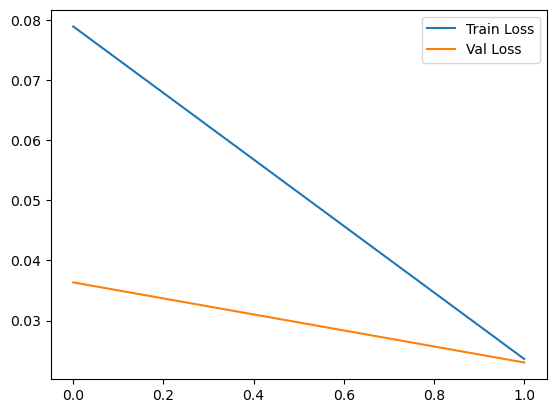

32/32 [==============================] - 0s 4ms/step


/home/marcos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/marcos/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


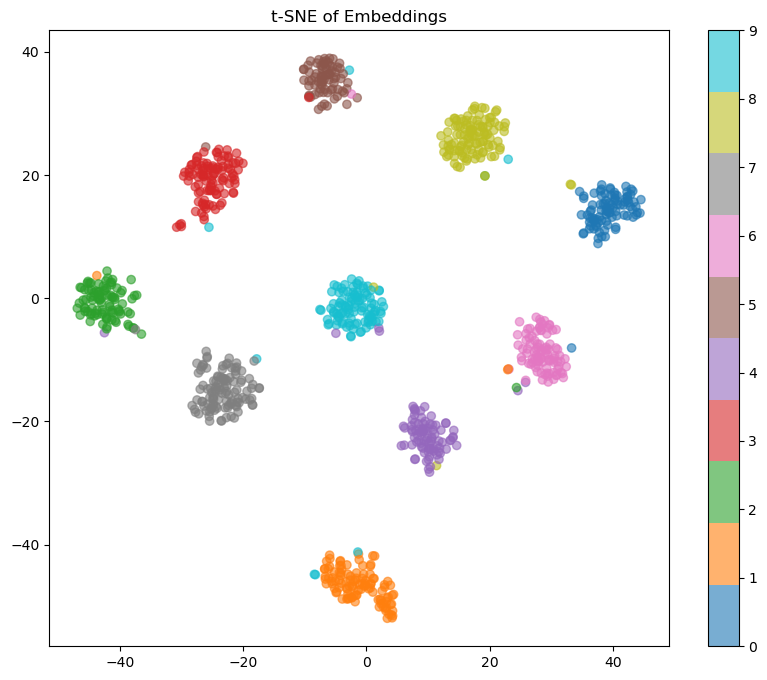

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)  # (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)    # (10000, 28, 28, 1)

# Improved triplet creation
def create_triplets(x, y, num_triplets=5000):
    triplets = []
    num_classes = 10
    class_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    for _ in range(num_triplets):
        anchor_class = np.random.randint(0, num_classes)
        while len(class_indices[anchor_class]) < 2:
            anchor_class = np.random.randint(0, num_classes)
        
        anchor_idx, pos_idx = np.random.choice(class_indices[anchor_class], 2, replace=False)
        
        neg_class = np.random.randint(0, num_classes)
        while neg_class == anchor_class or len(class_indices[neg_class]) == 0:
            neg_class = np.random.randint(0, num_classes)
        neg_idx = np.random.choice(class_indices[neg_class])
        
        triplets.append([x[anchor_idx], x[pos_idx], x[neg_idx]])
    
    return np.array(triplets)

# Create triplets
triplets_train = create_triplets(x_train, y_train, num_triplets=10000)
triplets_test = create_triplets(x_test, y_test, num_triplets=2000)

# Base embedding network
def build_embedding_network(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    return Model(inputs, x)

# Siamese model that outputs distances
def build_siamese_model(embedding_network):
    anchor_input = layers.Input(shape=input_shape)
    positive_input = layers.Input(shape=input_shape)
    negative_input = layers.Input(shape=input_shape)
    
    a_embed = embedding_network(anchor_input)
    p_embed = embedding_network(positive_input)
    n_embed = embedding_network(negative_input)
    
    pos_dist = tf.reduce_sum(tf.square(a_embed - p_embed), axis=1, keepdims=True)
    neg_dist = tf.reduce_sum(tf.square(a_embed - n_embed), axis=1, keepdims=True)
    
    # Stack distances along last axis
    distances = layers.Concatenate(axis=-1)([pos_dist, neg_dist])
    return Model([anchor_input, positive_input, negative_input], distances)

# Triplet loss function
def triplet_loss(y_true, y_pred):
    pos_dist = y_pred[..., 0]  # Take first distance
    neg_dist = y_pred[..., 1]  # Take second distance
    margin = 0.5
    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)

# Build and compile
input_shape = x_train.shape[1:]
embedding_net = build_embedding_network(input_shape)
model = build_siamese_model(embedding_net)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=triplet_loss)

# Prepare data
anchor_train, positive_train, negative_train = triplets_train[:, 0], triplets_train[:, 1], triplets_train[:, 2]
anchor_test, positive_test, negative_test = triplets_test[:, 0], triplets_test[:, 1], triplets_test[:, 2]

# Create dummy targets (though they won't be used)
dummy_y_train = np.zeros(len(anchor_train))
dummy_y_test = np.zeros(len(anchor_test))

# Train
history = model.fit(
    [anchor_train, positive_train, negative_train],
    dummy_y_train,  # Dummy targets
    batch_size=128,
    epochs=2,
    validation_data=([anchor_test, positive_test, negative_test], dummy_y_test)
)

# Plot training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# Visualization helper
def visualize_embeddings(model, x, y, num_samples=1000):
    indices = np.random.choice(len(x), num_samples, replace=False)
    sample_images = x[indices]
    sample_labels = y[indices]
    
    embeddings = embedding_net.predict(sample_images)
    
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=sample_labels, cmap='tab10', alpha=0.6)
    plt.colorbar()
    plt.title('t-SNE of Embeddings')
    plt.show()

visualize_embeddings(embedding_net, x_test, y_test)